# Object Classification Training Model

Notebook ini berisi implementasi model klasifikasi objek menggunakan TensorFlow untuk mengklasifikasikan dokumen, KTP, KK, dan SIM.

## Step 1: Setup Environment dan Import Library

In [ ]:
# Import library yang dibutuhkan
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

## Step 2: Menentukan lokasi Dataset

In [9]:
# Set path ke dataset
dataset_dir = "./dataset"

## Step 3: Fungsi-fungsi Utilitas Dataset

In [10]:
def parse_voc_xml(xml_path):
    """Fungsi untuk mengurai file XML format Pascal VOC"""
    import xml.etree.ElementTree as ET
    tree = ET.parse(xml_path)
    root = tree.getroot()

    objects = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        objects.append((name,))
    return objects

def load_dataset(dataset_dir, subset):
    """Fungsi untuk memuat dataset dari direktori"""
    images = []
    labels = []
    label_map = {'document': 0, 'KTP': 1, 'KK': 2, 'SIM': 3}
    folder_path = os.path.join(dataset_dir, subset)

    if not os.path.exists(folder_path):
        raise ValueError(f"Folder tidak ditemukan: {folder_path}")

    for file in os.listdir(folder_path):
        if file.endswith(".xml"):
            xml_path = os.path.join(folder_path, file)
            try:
                objects = parse_voc_xml(xml_path)
                if len(objects) > 0:
                    image_name = file.replace(".xml", "") + ".jpg"
                    image_path = os.path.join(folder_path, image_name)
                    if os.path.exists(image_path):
                        img = cv2.imread(image_path)
                        if img is not None:
                            img = cv2.resize(img, (256, 256))
                            img = img.astype('float32') / 255.0
                            images.append(img)
                            labels.append(label_map[objects[0][0]])
                        else:
                            print(f"[Warning] Gambar tidak dapat dibaca: {image_path}")
                    else:
                        print(f"[Warning] Path gambar tidak ditemukan: {image_path}")
            except Exception as e:
                print(f"[Error] Gagal memproses {xml_path}: {str(e)}")

    return np.array(images), np.array(labels)

## Step 4: Arsitektur Model

In [ ]:
def create_model():
    """Membuat arsitektur model CNN untuk klasifikasi"""
    input_layer = Input(shape=(256, 256, 3))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = Dense(4, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output, name="model_klasifikasi")
    return model

## Step 5: Load dan Preprocessing Dataset

In [12]:
# Memuat dataset
try:
    X_train, y_train = load_dataset(dataset_dir, "train")
    X_valid, y_valid = load_dataset(dataset_dir, "valid")
    X_test, y_test = load_dataset(dataset_dir, "test")

    # Konversi labels ke one-hot encoding
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
    y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=4)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

    print("Dataset shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

except Exception as e:
    print(f"Error loading dataset: {str(e)}")

Dataset shapes:
X_train: (665, 256, 256, 3), y_train: (665, 4)
X_valid: (63, 256, 256, 3), y_valid: (63, 4)
X_test: (15, 256, 256, 3), y_test: (15, 4)


## Step 6: Training Model

In [13]:
# Membuat dan compile model
model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Menampilkan ringkasan model
model.summary()

# Callback untuk early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Training model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping]
)

# Evaluasi model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")

Model: "model_klasifikasi"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,648,964 (128.36 MB)

 Trainable params: 33,648,964 (128.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.3605 - loss: 1.8494 - val_accuracy: 0.5397 - val_loss: 1.1407
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6499 - loss: 0.8275 - val_accuracy: 0.6349 - val_loss: 0.9630
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7970 - loss: 0.4959 - val_accuracy: 0.6349 - val_loss: 0.8403
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8648 - loss: 0.3547 - val_accuracy: 0.9048 - val_loss: 0.3693
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9053 - loss: 0.2644 - val_accuracy: 0.8413 - val_loss: 0.3935
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9350 - loss: 0.1788 - val_accuracy: 0.9206 - val_loss: 0.2450
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9621 - loss: 0.0905 - val_accuracy: 0.9365 - val_loss: 0.1771
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9699 - loss: 0.1077 - val_accuracy: 0.8730 - val_loss:

## Step 7: Visualisasi Hasil Training

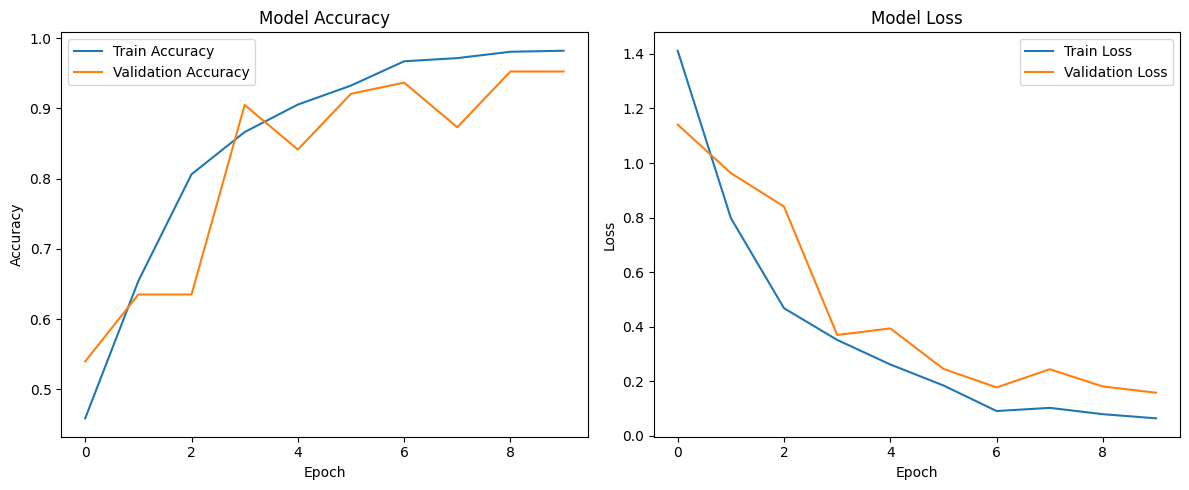

In [ ]:
def plot_training_history(history):
    # Memvisualisasikan history pelatihan model
    plt.figure(figsize=(12, 5))

    # Plot akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualisasi hasil training
plot_training_history(history)

## Step 8: Menyimpan Model

In [15]:
# Menyimpan model dalam format H5
model_save_path = 'model_klasifikasi.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite
tflite_save_path = 'model_klasifikasi.tflite'
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_model)
print(f"TFLite model saved to {tflite_save_path}")

Model saved to model_klasifikasi.h5
INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmpvyt20eb_\assets


INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmpvyt20eb_\assets


Saved artifact at 'C:\Users\ACER\AppData\Local\Temp\tmpvyt20eb_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  1948544394704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1948564977232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1948564977616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1948564978192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1948564978384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1948564978960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1948564977808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1948564979536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1948565389776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1948565390928: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLit

## Step 9: Fungsi Prediksi

In [ ]:
def predict_image(image_path):
    # Melakukan prediksi pada gambar baru
    # Load dan preprocess gambar
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Tidak dapat membaca gambar: {image_path}")

    img = cv2.resize(img, (256, 256))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    # Prediksi
    prediction = model.predict(img)
    class_idx = np.argmax(prediction[0])
    confidence = prediction[0][class_idx]

    # Mapping index ke label
    label_map = {0: 'document', 1: 'KTP', 2: 'KK', 3: 'SIM'}
    predicted_class = label_map[class_idx]

    return predicted_class, confidence

## Step 10: Uji Model dengan Gambar Baru

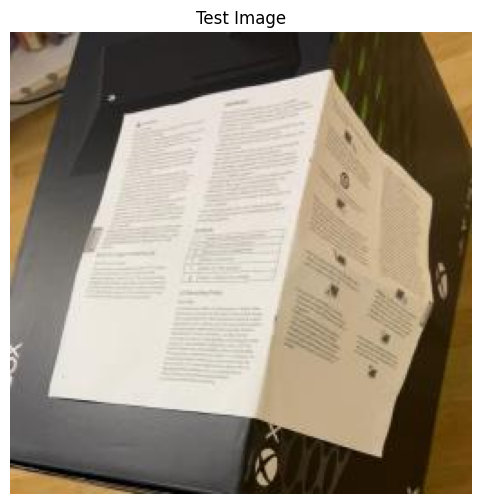

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted class: document
Confidence: 98.65%


In [39]:
# Contoh penggunaan fungsi prediksi
test_image_path = './dataset/test/0RiRtm_2_png_jpg.rf.9d059fb986e8d82f1c1f42c28f79e383.jpg'  # Ganti dengan path gambar test Anda

try:
    # Load dan tampilkan gambar
    img = cv2.imread(test_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Test Image')
    plt.show()

    # Lakukan prediksi
    predicted_class, confidence = predict_image(test_image_path)
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.2%}")

except Exception as e:
    print(f"Error during prediction: {str(e)}")

## Step 11: Evaluasi Model Lebih Lanjut

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


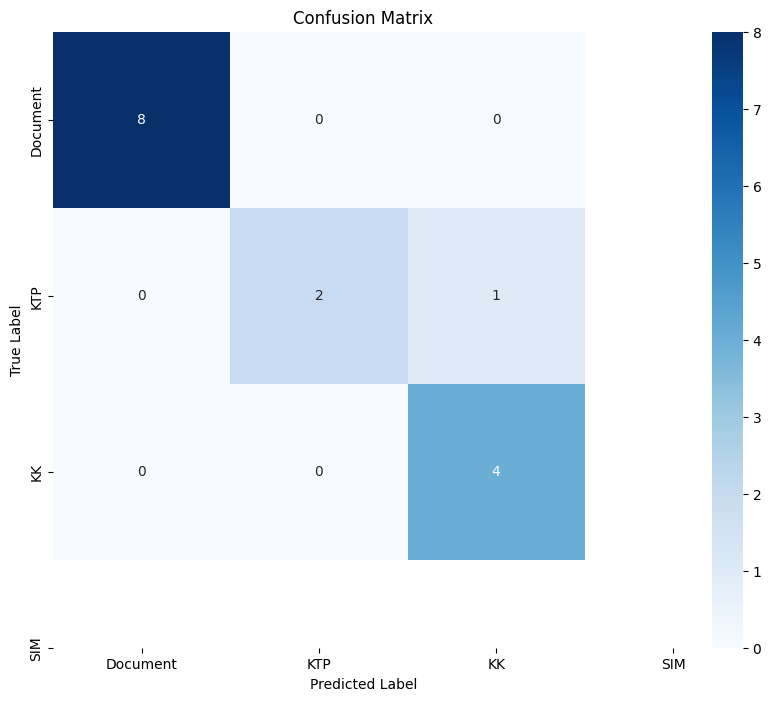

In [29]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Prediksi pada data test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Buat confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
class_names = ['Document', 'KTP', 'KK', 'SIM']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Kesimpulan dan Rekomendasi

Notebook ini telah mendemonstrasikan implementasi lengkap model klasifikasi dokumen dengan beberapa peningkatan:

1. Arsitektur yang lebih dalam dengan multiple convolutional layers
2. Implementasi early stopping untuk mencegah overfitting
3. Visualisasi hasil yang lebih komprehensif
4. Evaluasi model menggunakan confusion matrix

Untuk meningkatkan performa model lebih lanjut, beberapa hal yang bisa dilakukan:

1. Implementasi data augmentation
2. Menggunakan transfer learning dengan pre-trained models
3. Menambah jumlah data training
4. Fine-tuning hyperparameter
5. Implementasi cross-validation